In [1]:
import argparse
import os
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
if not in_notebook:
    args = parse_args()
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )

else:
    print("Running in a notebook")
    well_fov = "F4-1"
    patient = "NF0037_T1-Z-1"
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}/"
).resolve(strict=True)
mask_input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve(strict=True)
output_file_path = pathlib.Path(mask_input_dir / "cytoplasm_mask.tiff").resolve()

Running in a notebook


In [3]:
# get all the masks
nuclei_masks_path = pathlib.Path(
    mask_input_dir / "nuclei_masks_reconstructed_corrected.tiff"
).resolve(strict=True)
cell_masks_path = pathlib.Path(mask_input_dir / "cell_masks_watershed.tiff").resolve(
    strict=True
)

nuclei_masks = read_zstack_image(nuclei_masks_path)
cell_masks = read_zstack_image(cell_masks_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0037_T1-Z-1/segmentation_masks/F4-1/nuclei_masks_reconstructed_corrected.tiff'

In [ ]:
cytoplasm_masks = np.zeros_like(cell_masks)
# filter masks that are not the background
for z_slice_index in range(nuclei_masks.shape[0]):
    nuclei_slice_mask = nuclei_masks[z_slice_index]
    cell_slice_mask = cell_masks[z_slice_index]
    cytoplasm_mask = cell_slice_mask.copy()
    cytoplasm_mask[nuclei_slice_mask > 0] = 0  # subtraction happens here
    cytoplasm_masks[z_slice_index] = cytoplasm_mask

In [11]:
tifffile.imwrite(output_file_path, cytoplasm_masks)

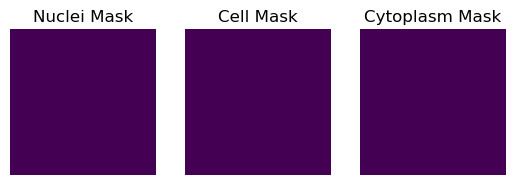

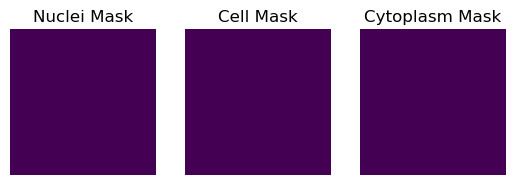

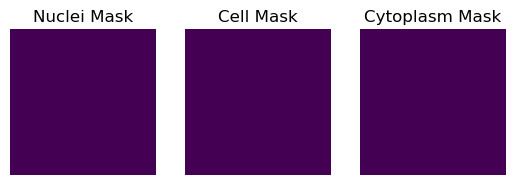

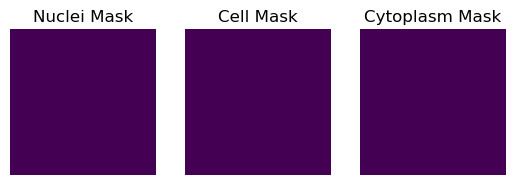

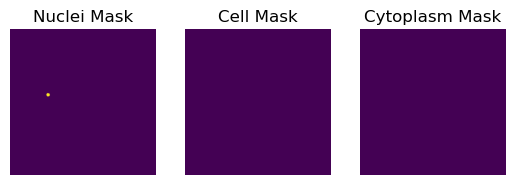

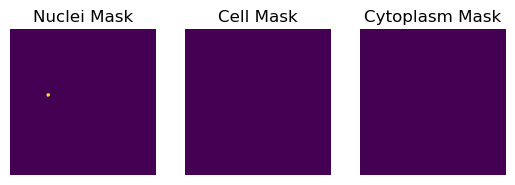

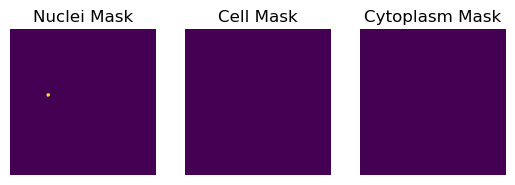

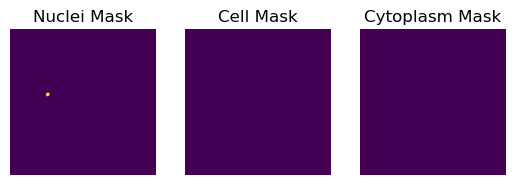

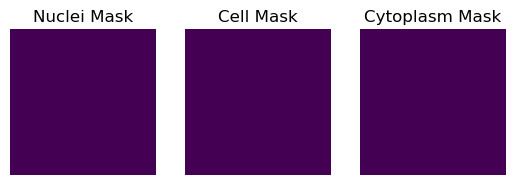

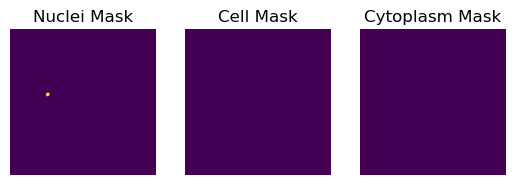

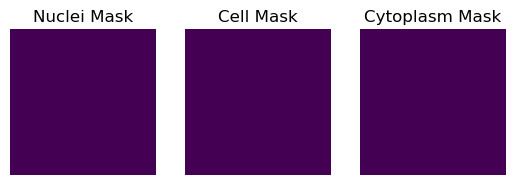

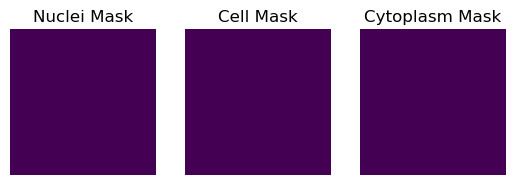

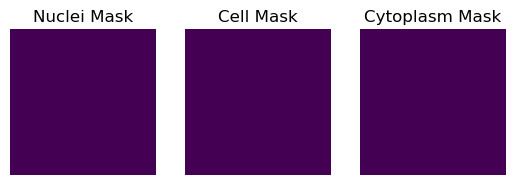

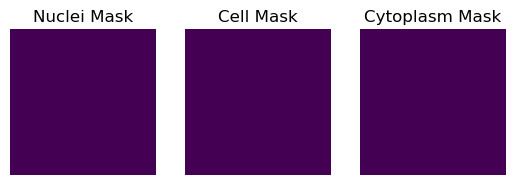

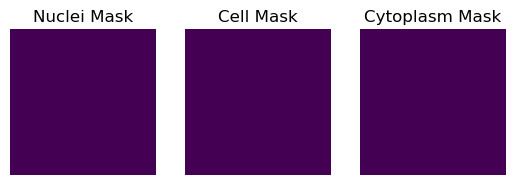

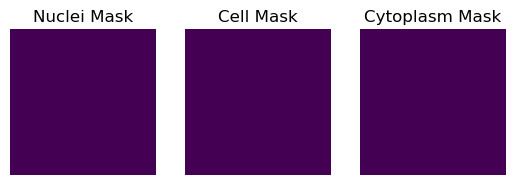

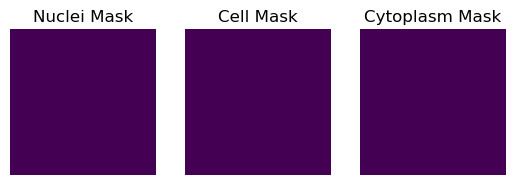

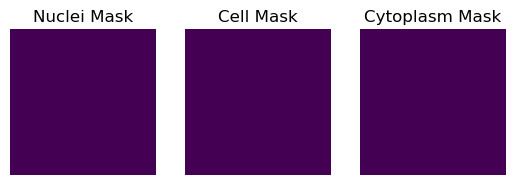

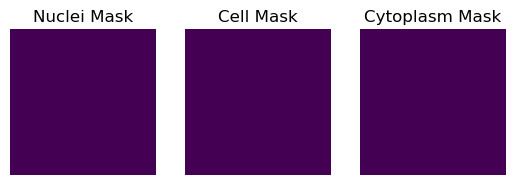

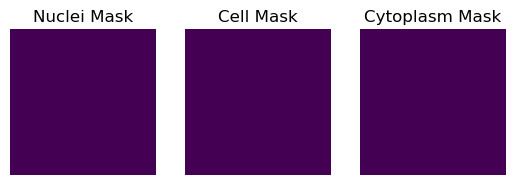

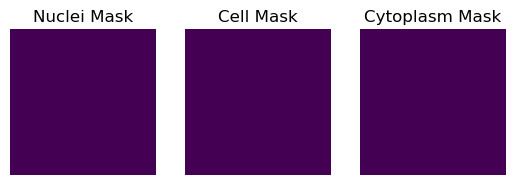

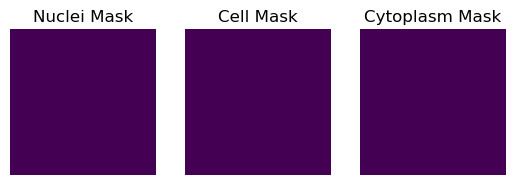

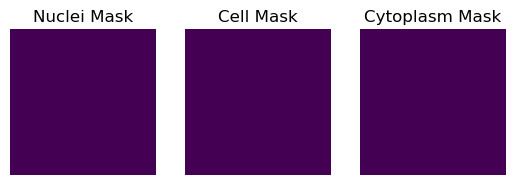

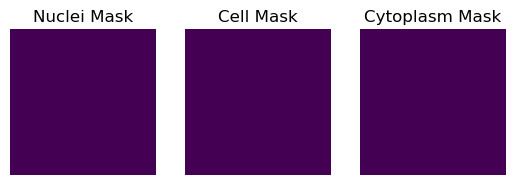

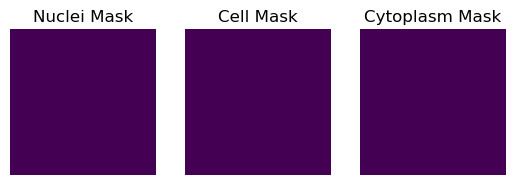

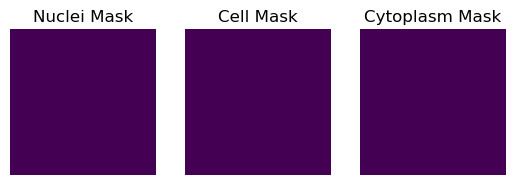

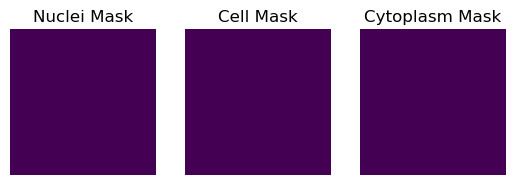

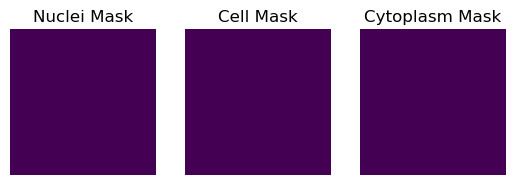

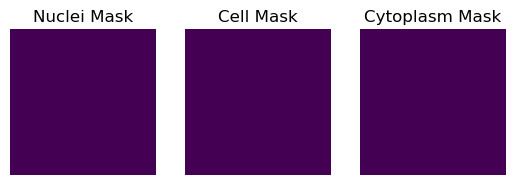

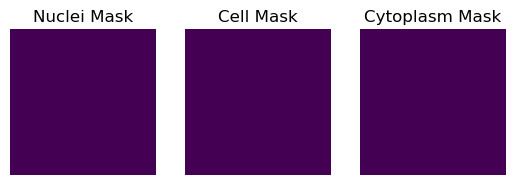

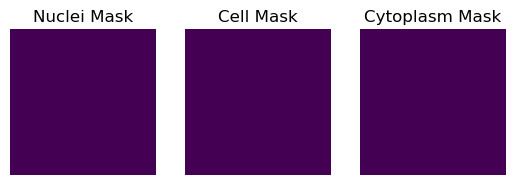

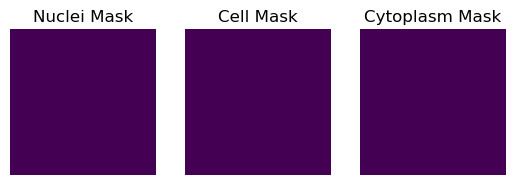

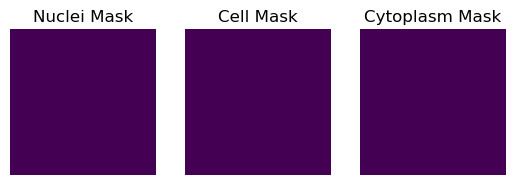

In [12]:
if in_notebook:
    for z in range(nuclei_masks.shape[0]):
        plt.subplot(1, 3, 1)
        plt.imshow(nuclei_masks[z])
        plt.title("Nuclei Mask")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(cell_masks[z])
        plt.title("Cell Mask")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(cytoplasm_masks[z])
        plt.title("Cytoplasm Mask")
        plt.axis("off")
        plt.show()